# Causal programming demo

## Dependencies

In [65]:
(require '[acausal.core
           :refer [model model->svg 
                   query query->latex 
                   data data->latex
                   identify
                   latex]]
         :reload)

In [37]:
(require 'acausal.core :reload)

## Define a model

Let $X$ be smoking, $Y$ be cancer, and $Z$ be tar (on lungs).

Assume that the effect of smoking on caner is mediated by tar. However, there may be a latent factor that affects both smoking and cancer. These assumptions can be summarized in the following model:

$$ X = f_X(\epsilon_X) $$
$$ Z = f_Z(x, \epsilon_Z) $$
$$ Y = f_Y(z, \epsilon_Y) $$
$$ \epsilon_X \not\bot\!\!\bot \epsilon_Y$$

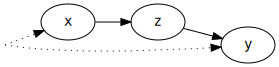

In [72]:
(def m
    "Smoking and cancer model"
    (model
        {:x []
         :z [:x]
         :y [:z]}
        #{:x :y}))

(model->svg fisher)

In [73]:
(def q
    (query [:y] :do [:x]))

(query->latex q)

In [74]:
(def d
    (data [:x :y :z]))

(data->latex d)

In [75]:
(identify m q d)

## Model

$\text{malaria} = f(\epsilon_{\text{malaria}})$

$\text{flu} = f(\epsilon_{\text{flu}})$

$\text{fever} = f(\text{malaria}, \text{flu}, \epsilon_{\text{fever}})$

In [46]:
(def m
    "Malaria/flu model"
    (model
        {:malaria []
         :flu []
         :fever [:malaria :flu]}))

m

#acausal.core.Model{:vars #{:malaria :flu :fever}, :latents #{}, :parents {:malaria #{}, :flu #{}, :fever #{:malaria :flu}}, :children {:malaria #{:fever}, :flu #{:fever}, :fever #{}}}

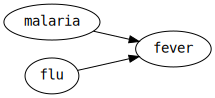

In [18]:
(model->svg m)

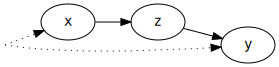

In [16]:
(def mediated
    (model
        {:x []
         :z [:x]
         :y [:z]}
        #{:x :y}))

(model->svg mediated)

## Define a model

$$w = f_w(\epsilon_w)$$
$$x = f_x(\epsilon_x)$$
$$y = f_y(z, \epsilon_y)$$
$$z = f_z(w, x, \epsilon_z)$$

$$\epsilon_w \not ⫫ \epsilon_z$$
$$\epsilon_x \not ⫫ \epsilon_y$$

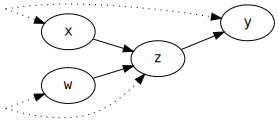

In [41]:
(def example
    (model
        {:w []
         :x []
         :y [:z]
         :z [:w :x]}
        #{:w :z}
        #{:x :y}))

(model->svg example)

In [39]:
(query->latex (query [:y] :do [] :given [:z]))

In [38]:
(data->latex (data [:x :y] :do* [:z_1 :z_2]))